# UNET SEGMENTATION

## 1. Load data to google colaboratory

In [1]:
# Load data to google colaboratory (I used GPU)
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

!df -h
!unzip gdrive/'My Drive'/b.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   25G  316G   8% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/sda1       365G   30G  336G   9% /opt/bin
tmpfs           6.4G   12K  6.4G   1% /var/colab
shm             6.0G     0  6.0G   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  1.3G   14G   9% /content/gdrive
Archive:  gdrive/My Drive/b.z

## 2. Import and set seed

In [2]:
# Import libraries
import os
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
# Seed
seed = 1000
random.seed = seed
np.random.seed = seed
tf.seed = seed

## 3. Prepare data

In [4]:
# Create Data Generator

class DataGenerator(keras.utils.Sequence):
    def __init__(self, files_X, files_y, path, batch_size, image_size):
        self.files_X = files_X
        self.files_y = files_y 
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
    
    
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.files_X):
            self.batch_size = len(self.files_X) - index * self.batch_size
        
        files_batch_X = self.files_X[index * self.batch_size : (index + 1) * self.batch_size]
        files_batch_y = self.files_y[index * self.batch_size : (index + 1) * self.batch_size]
        
        X = []
        y  = []
        
        for file_X, file_y in zip(files_batch_X, files_batch_y):
        
            ## Reading Image and normalization
            image_X = cv2.imread(os.path.join(self.path, "X", file_X))
            image_X = cv2.resize(image_X, self.image_size)
            image_X = image_X/255.0
            
            image_y = cv2.imread(os.path.join(self.path, "y", file_y), 0)
            image_y = cv2.resize(image_y, self.image_size)
            
            mask1 = np.array(image_y == 1) # 3 classes - divide to 3 layers
            mask2 = np.array(image_y == 2)
            mask3 = np.array(image_y == 3)
             
            mask = np.dstack((mask1, mask2, mask3))
            
            X.append(image_X)
            y.append(mask)
            
        X = np.array(X)
        y  = np.array(y)
        return X, y
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.files_X) / float(self.batch_size)))

In [5]:
#Get train data for checking
train_path = "dataset/train/"
train_path_X = "dataset/train/X/"
train_path_y = "dataset/train/y/"

image_size = (1280, 720) # all images have NOT the same size

train_files_X = next(os.walk(train_path_X))[2] # 2 - files
train_files_y = next(os.walk(train_path_y))[2] # 2 - files

In [6]:
#Get validation data for checking
valid_path = "dataset/validation/"
valid_path_X = "dataset/validation/X/"
valid_path_y = "dataset/validation/y/"

valid_files_X = next(os.walk(valid_path_X))[2] # 2 - files
valid_files_y = next(os.walk(valid_path_y))[2] # 2 - files

In [7]:
# Check batches
checking_image = DataGenerator(train_files_X, train_files_y, train_path, 1, image_size)
check_x, check_y = checking_image.__getitem__(1)
print("Shape of one X image:", check_x.shape, "and y:", check_y.shape)

Shape of one X image: (1, 720, 1280, 3) and y: (1, 720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


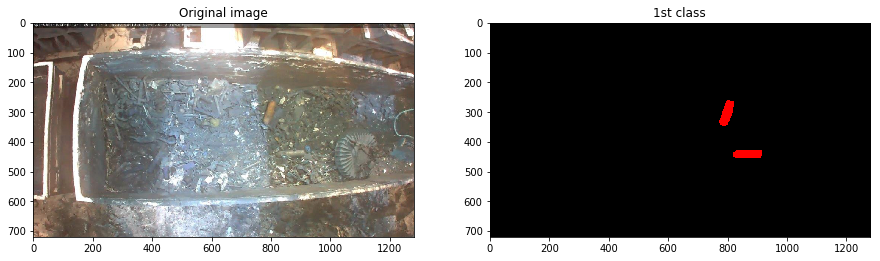

In [8]:
# Choose one train image and plot it
image = 0
fig = plt.figure()
fig.set_size_inches(w=15,h=10)
fig.subplots_adjust()
ax = fig.add_subplot(2, 2, 1)

ax.title.set_text('Original image')
ax.imshow(check_x[image])

ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('1st class')
ax.imshow(check_y[image]*255.)

Shape of one X image: (1, 720, 1280, 3) and y: (1, 720, 1280, 3)


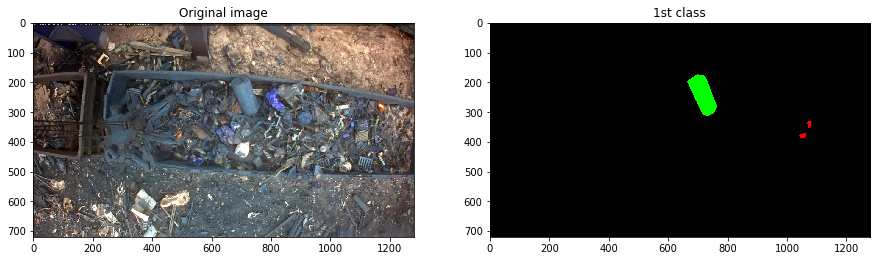

In [9]:
# Choose one valid image and plot it
checking_image = DataGenerator(train_files_X, train_files_y, train_path, 1, image_size)
check_x, check_y = checking_image.__getitem__(0)
print("Shape of one X image:", check_x.shape, "and y:", check_y.shape)

# Plot
image = 0
fig = plt.figure()
fig.set_size_inches(w=15,h=10)
fig.subplots_adjust()
ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Original image')
ax.imshow(check_x[image])

ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('1st class')
ax.imshow(check_y[image]*255)

In [10]:
# Checking. All layers of masks are equals or not?
k = 0
for mask_file in next(os.walk(train_path_y))[2]:
    mask = cv2.imread(os.path.join(train_path, "y", mask_file))
    equals01 = [mask[:,:,0] == mask[:,:,1]]
    equals02 = [mask[:,:,0] == mask[:,:,1]]
    if np.amax(equals01 == 0 or equals02 == 0):
        k += 1
if k==0:
    print('layers 0,1 and 2 are equals for masks')
else:
    print('layers 0,1 and 2 are NOT equals for masks') 

layers 0,1 and 2 are equals for masks


## 4. Create neural network model

In [11]:
# Create blocks for network. It works ok with BatchNormalization

def conv_pool_layer(x, filters):
    conv = keras.layers.Conv2D(filters, (3, 3), padding = "same", strides = 1, activation = "relu")(x)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Conv2D(filters, (3, 3), padding = "same", strides = 1, activation = "relu")(conv)
    conv = keras.layers.BatchNormalization()(conv)
    pool = keras.layers.MaxPool2D((2, 2), (2, 2))(conv)
    return conv, pool

def conv_layer(x, filters):
    conv = keras.layers.Conv2D(filters, (3, 3), padding = "same", strides = 1, activation = "relu")(x)
    conv = keras.layers.BatchNormalization()(conv))
    conv = keras.layers.Conv2D(filters, (3, 3), padding = "same", strides = 1, activation = "relu")(conv)
    conv = keras.layers.BatchNormalization()(conv)
    return conv

def conv_upconv_layer(x, copy, filters):
    up_conv = keras.layers.Conv2DTranspose(filters, (2, 2), strides = (2, 2), padding = 'same') (x)
    concat = keras.layers.Concatenate()([up_conv, copy])
    conv = keras.layers.Conv2D(filters, (3, 3), padding = "same", strides = 1, activation = "relu")(concat)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Conv2D(filters, (3, 3), padding = "same", strides = 1, activation = "relu")(conv)
    conv = keras.layers.BatchNormalization()(conv)
    return conv

def last_layer(x):
    return keras.layers.Conv2D(3, (1, 1), padding="same", activation="sigmoid")(x)

In [12]:
# Build U-Net model
def U_Net(image_size):
    n = [16, 32, 64, 128, 256, 512]
    
    inputs = keras.layers.Input((image_size[1], image_size[0], 3))
    
    p0 = inputs
    c1, p1 = conv_pool_layer(p0, n[0]) 
    c2, p2 = conv_pool_layer(p1, n[1]) 
    c3, p3 = conv_pool_layer(p2, n[2]) 
    c4, p4 = conv_pool_layer(p3, n[3]) 
    #c5, p5 = conv_pool_layer(p4, n[4])
    
    #bn = conv_layer(p5, n[5])
    bn = conv_layer(p4, n[4])
    
    #u0 = conv_upconv_layer(bn, c5, n[4]) 
    #u1 = conv_upconv_layer(u0, c4, n[3]) 
    u1 = conv_upconv_layer(bn, c4, n[3]) 
    u2 = conv_upconv_layer(u1, c3, n[2]) 
    u3 = conv_upconv_layer(u2, c2, n[1]) 
    u4 = conv_upconv_layer(u3, c1, n[0]) 
    
    outputs = last_layer(u4)
    
    model = keras.models.Model(inputs, outputs)
    return model

## 5. Check model for low resolution data

In [13]:
# Create and show the model
image_size = (256, 128) # low resolution
model = U_Net(image_size)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 128, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 16) 2320        batch_normalization_v1[0][0]     
_____________________________________

In [14]:
# Train the model
batch_size = 8
epochs = 80

train_generator = DataGenerator(train_files_X, train_files_y, train_path, batch_size, image_size)
valid_generator = DataGenerator(valid_files_X, valid_files_y, valid_path, batch_size, image_size)

model_training = model.fit_generator(train_generator, validation_data = valid_generator, 
                   steps_per_epoch = train_generator.__len__(),
                   validation_steps = valid_generator.__len__(), epochs = epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/80
62/62 [==============================] - 11s 180ms/step - loss: 3.4988 - acc: 0.5747 - val_loss: 4.8154 - val_acc: 0.6999
Epoch 2/80
62/62 [==============================] - 3s 44ms/step - loss: 1.7699 - acc: 0.9101 - val_loss: 3.2334 - val_acc: 0.9872
Epoch 3/80
62/62 [==============================] - 3s 46ms/step - loss: 1.4618 - acc: 0.9900 - val_loss: 2.5261 - val_acc: 0.9945
Epoch 4/80
62/62 [==============================] - 3s 45ms/step - loss: 1.0567 - acc: 0.9950 - val_loss: 1.7479 - val_acc: 0.9945
Epoch 5/80
62/62 [==============================] - 3s 45ms/step - loss: 0.6867 - acc: 0.9951 - val_loss: 1.1369 - val_acc: 0.9945
Epoch 6/80
62/62 [==============================] - 3s 46ms/step - loss: 0.4384 - acc: 0.9951 - val_loss: 0.7288 - val_acc: 0.9945
Epoch 7/80
62/62 [==============================] - 3s 44ms/step - loss: 0.2959 - acc: 0.9952 - val_loss: 0.5272 - val_acc: 0.9945
Epoch 8/80
62/62 [===============

In [15]:
# Evaluate the model
scores = model.evaluate_generator(valid_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 99.50%


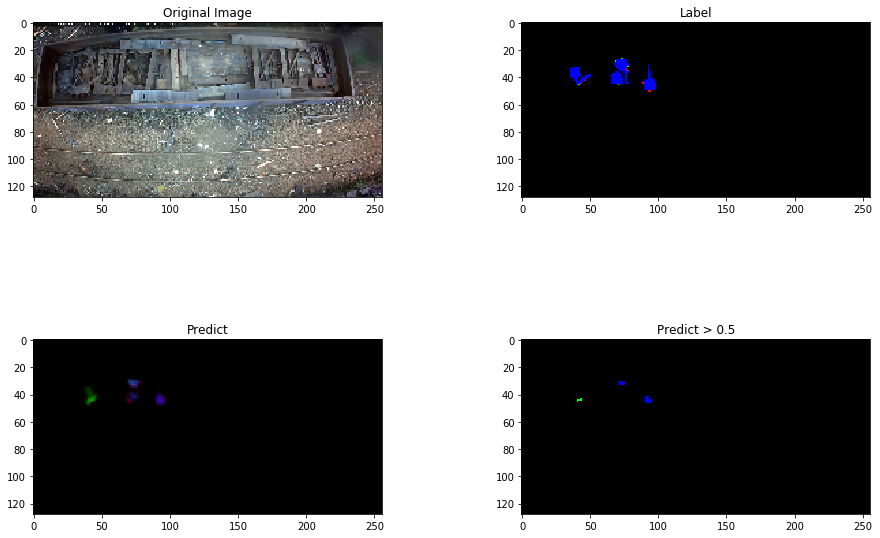

In [16]:
# Check prediction of train data
check_X, check_y = train_generator.__getitem__(1)
result = model.predict(check_X)

fig = plt.figure()
fig.set_size_inches(w=15,h=10)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Original Image')
ax.imshow(check_X[0], cmap="gray")

ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('Label')
ax.imshow(check_y[0]*255, cmap="gray")

ax = fig.add_subplot(2, 2, 3)
ax.title.set_text('Predict')
ax.imshow((result[0]*255).astype(int), cmap="gray")

ax = fig.add_subplot(2, 2, 4)
ax.title.set_text('Predict > 0.5')
ax.imshow(((result[0]>0.5)*255).astype(int), cmap="gray")

0.96983135

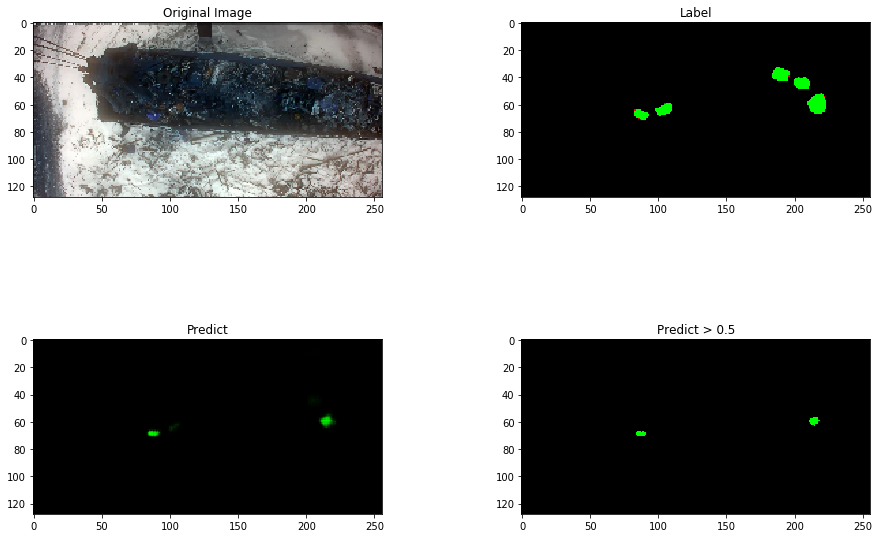

In [17]:
# Check prediction of valid data
check_X, check_y = valid_generator.__getitem__(1)
result = model.predict(check_X)

fig = plt.figure()
fig.set_size_inches(w=15,h=10)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Original Image')
ax.imshow(check_X[0], cmap="gray")

ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('Label')
ax.imshow(check_y[0]*255, cmap="gray")

ax = fig.add_subplot(2, 2, 3)
ax.title.set_text('Predict')
ax.imshow((result[0]*255).astype(int), cmap="gray")

ax = fig.add_subplot(2, 2, 4)
ax.title.set_text('Predict > 0.5')
ax.imshow(((result[0]>0.5)*255).astype(int), cmap="gray")

np.amax(result[0])

## 6. Create model for fully resolution data

In [18]:
# Create and show the model
image_size = (1280, 720)
model = U_Net(image_size)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 720, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 720, 1280, 16 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 720, 1280, 16 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 720, 1280, 16 2320        batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
batch_norm

In [19]:
# Parameters of neural network
batch_size = 2
epochs = 30

In [20]:
# Train the model

train_generator = DataGenerator(train_files_X, train_files_y, train_path, batch_size, image_size)
valid_generator = DataGenerator(valid_files_X, valid_files_y, valid_path, batch_size, image_size)

model_training = model.fit_generator(train_generator, validation_data = valid_generator, 
                   steps_per_epoch = train_generator.__len__(),
                   validation_steps = valid_generator.__len__(), epochs = epochs)

Epoch 1/30
246/246 [==============================] - 86s 350ms/step - loss: 0.6771 - acc: 0.8986 - val_loss: 0.4625 - val_acc: 0.9945
Epoch 2/30
246/246 [==============================] - 60s 245ms/step - loss: 0.1251 - acc: 0.9950 - val_loss: 0.1348 - val_acc: 0.9939
Epoch 3/30
246/246 [==============================] - 60s 245ms/step - loss: 0.0485 - acc: 0.9950 - val_loss: 0.0925 - val_acc: 0.9941
Epoch 4/30
246/246 [==============================] - 60s 245ms/step - loss: 0.0349 - acc: 0.9950 - val_loss: 0.0754 - val_acc: 0.9945
Epoch 5/30
246/246 [==============================] - 60s 245ms/step - loss: 0.0309 - acc: 0.9949 - val_loss: 0.0788 - val_acc: 0.9942
Epoch 6/30
246/246 [==============================] - 60s 245ms/step - loss: 0.0291 - acc: 0.9949 - val_loss: 0.0609 - val_acc: 0.9946
Epoch 7/30
246/246 [==============================] - 60s 244ms/step - loss: 0.0281 - acc: 0.9950 - val_loss: 0.1938 - val_acc: 0.9726
Epoch 8/30
246/246 [==============================] - 6

In [21]:
# Evaluate the model
scores = model.evaluate_generator(valid_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 99.40%


In [22]:
# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5
model.save_weights("U_Net_weights.h5")

# Save model
model.save("model.h5")

### Here you can close the notebook and relax
After it you can load the model without training. But please reload all variables which located before the network.

In [23]:
# Load json and create model
train_generator = DataGenerator(train_files_X, train_files_y, train_path, batch_size, image_size)
valid_generator = DataGenerator(valid_files_X, valid_files_y, valid_path, batch_size, image_size)

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("U_Net_weights.h5")
print("Model are loaded from disk")
 
# Evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate_generator(train_generator, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Model are loaded from disk
acc: 99.45%


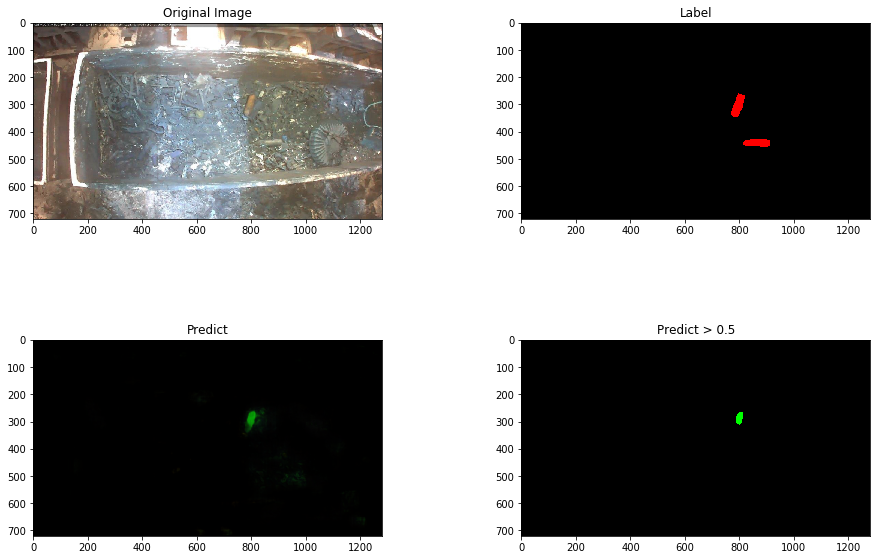

In [24]:
# Check prediction of train data
check_X, check_y = train_generator.__getitem__(1)
result = loaded_model.predict(check_X)

fig = plt.figure()
fig.set_size_inches(w=15,h=10)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Original Image')
ax.imshow(check_X[0], cmap="gray")

ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('Label')
ax.imshow(check_y[0]*255, cmap="gray")

ax = fig.add_subplot(2, 2, 3)
ax.title.set_text('Predict')
ax.imshow((result[0]*255).astype(int), cmap="gray")

ax = fig.add_subplot(2, 2, 4)
ax.title.set_text('Predict > 0.5')
ax.imshow(((result[0]>0.5)*255).astype(int), cmap="gray")

0.9975235

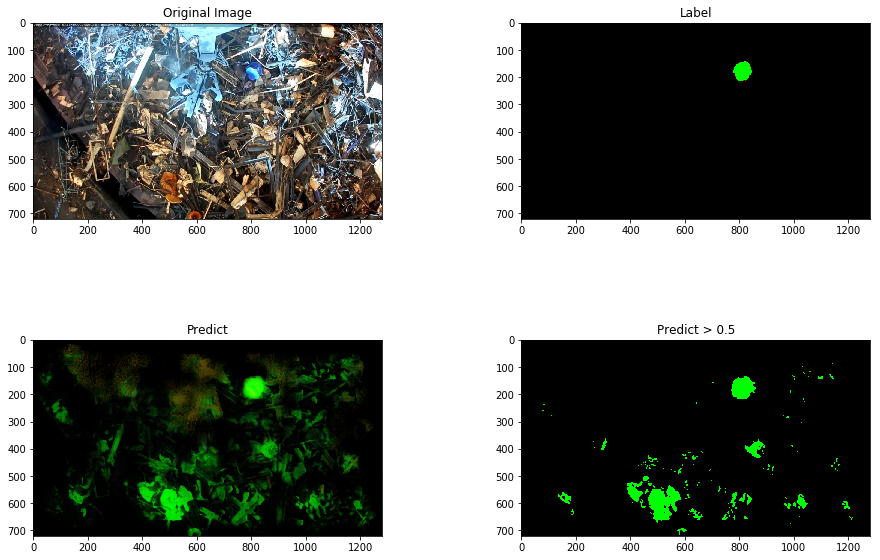

In [25]:
# Check prediction of valid data
check_X, check_y = valid_generator.__getitem__(0)
result = loaded_model.predict(check_X)

fig = plt.figure()
fig.set_size_inches(w=15,h=10)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Original Image')
ax.imshow(check_X[0], cmap="gray")

ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('Label')
ax.imshow(check_y[0]*255, cmap="gray")

ax = fig.add_subplot(2, 2, 3)
ax.title.set_text('Predict')
ax.imshow((result[0]*255).astype(int), cmap="gray")

ax = fig.add_subplot(2, 2, 4)
ax.title.set_text('Predict > 0.5')
ax.imshow(((result[0]>0.5)*255).astype(int), cmap="gray")

np.amax(result[0])